## Prophet for Business Forecasting


Business time series data are everywhere. Can we come up with 20 examples for business time series data? Let’s play a popular game Family Feud to find out. Family Feud is a game show where two teams compete to guess the most popular answers to survey questions within a time limit. I can think of retail, manufacturing, phone services, and airline traffic for business time series data. In retail, there is daily and weekly sales volume. There is daily and weekly store traffic. And there are daily inventory levels. In manufacturing, there are daily, weekly, or monthly production volumes. In airline traffic, the numbers of passengers per day are business time series data. If it is a cargo airline, shipment volumes over time. Well. I think that’s enough to score the Family Feud game. You probably get my point — business time series data are everywhere. Analyzing and forecasting these time series is critical for data scientists. When we analyze the past patterns of business time series to forecast the future, the forecasts can provide valuable insights for decision-making, resource planning, and performance optimization within organizations.

Business time series data exhibit seasonality and trend patterns. Seasonality is recurring patterns that follow a regular schedule such as days, weeks, or months. Business time series also have underlying trends that show long-term tendencies. Trends can be upward, indicating growth, or downward, indicating decline. These trends may be influenced by various factors such as market conditions, technological advancements, or changes in consumer behavior. In addition, holiday effects are noticeable too. For example, retail sales will spike high around events like Super Ball, Thanksgiving or Christmas, and New Year’s Eve. It makes sense to design a mathematical model that can identify trends, seasonality, and holiday effects. A well-recognized model is the Generalized Additive Model (GAMs).

The term business time series data is used to label the types of time series that exhibit trend, seasonality, and holiday patterns. There are time series that do not exhibit these patterns and we can call them non-business time series. For example, astronomical data such as the positions and brightness of stars over time do not exhibit these patterns. Heart rate, blood pressure, and body temperature data should not exhibit a rising trend or fluctuate widely according to holidays (although it may happen in exuberant situations!). The non-business time series data probably will fit better with domain-specific model specifications rather than GAMs, though GAMs still can be tested to see their predictability.

The Generalized Additive Models (GAMs)

A business time series exhibits trend, seasonality, and holiday effects. It is well characterized by GAMs, which consider a time series to consist of three components: a linear trend, a seasonal effect, and any holiday effect. GAMs were originally invented by Trevor Hastie and Robert Tibshirani in 1986 [1]. The idea of GAMs is intuitive:

*   Relationships between the individual predictors and the dependent variable follow smooth patterns that can be linear or nonlinear. Figure (1) illustrates the relationship between x1 and y can be nonlinear.
*   Additive: these smooth relationships can be estimated simultaneously and then added up.

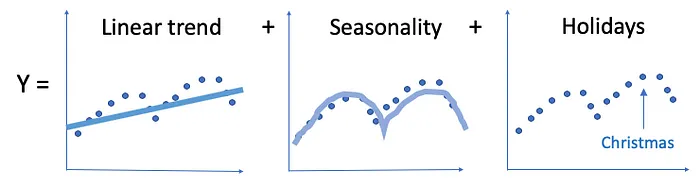


GAMs have the following components:

y(t) = T(t) + S(t) + H(t) + ε(t)


*   T(t): Trend,
*   S(t): Seasonality for weekly, monthly, and yearly seasonality,
*   H(t): Holiday effects for the effects of holidays that occur on potentially irregular schedules over one or more days,

and ε(t) is for any idiosyncratic changes that are not accommodated by the model. The predictor is t or time.

The above GAM framework is characterized by Prophet. Let’s understand what the Prophet module can do.


## The Case for Prophet

Prophet is an open-source library for time series by Facebook. We chose Prophet to be the first chapter because it is intuitive, easy to use, and has great visualization tools. Data scientists and engineers who need to build forecasting models quickly will find it very helpful. Let’s list some of its features.

First, Prophet has automated many of the hyperparameters. It’s engineered to select the best model automatically and you are advised to adopt the default settings. Later I still will show you how to fine-tune the hyper-parameters of Prophet and you can evaluate the outcomes.

Second, Prophet has user-friendly APIs for modeling and forecasting. This is especially useful when you need to showcase a proof-of-concept model and explain the model outcomes.

Third, it can integrate easily with other Python libraries and tools, such as Pandas, NumPy, and Matplotlib. This makes it easy to incorporate Prophet into your existing workflows and visualize your forecasts.

Fourth, Prophet has extensive documentation that includes tutorials, examples, and API references. This makes it easy to learn how to use the library and understand how to build forecasting models.

Let’s start to use the Prophet.

## Data preparation

Our dataset is about the number of visitors to an academic teaching notes website from Kaggle.com. This dataset has daily counts of page loads, unique visitors, first-time visitors, and returning visitors. The dataset covers the date range from September 14, 2014, to August 19, 2020. We will take more recent data to build the model.

Prophet is a tool for univariate time series. It requires two columns with the names “ds” and “y”.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!pip install prophet

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn import metrics
from prophet.diagnostics import cross_validation
warnings.filterwarnings('ignore')

In [4]:
# If you use your local computer, use this. You will need to download the data to your local folder.
path = '/content/drive/MyDrive/DataSets/daily-website-visitors.csv'
data = pd.read_csv(path,  thousands=',')

# convert string to datetime64
data["Date"] = pd.to_datetime(data["Date"])
data = data[['First.Time.Visits','Date']]
data.columns = ['y','ds']
data['y'] = pd.to_numeric(data['y'], errors='coerce')
data = data[data['ds']>=pd.to_datetime('2017-01-01')]
data = data.sort_values(by='ds')
data

,y,ds
840,832,2017-01-01
841,1448,2017-01-02
842,1970,2017-01-03
843,2226,2017-01-04
844,2058,2017-01-05
...,...,...
2162,1373,2020-08-15
2163,1686,2020-08-16
2164,2181,2020-08-17
2165,2184,2020-08-18


## Plot the data

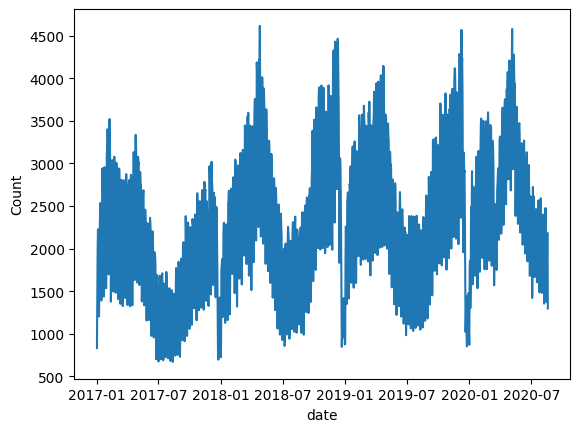

In [5]:
# create line plot of sales data
plt.plot(data['ds'], data["y"])
plt.xlabel("date")
plt.ylabel("Count")
plt.show()

## In-time and out-of-time data split

Time series modeling typically uses in-time and out-of-time data for model training and testing to evaluate the model’s ability to predict future values based on past observations. In-time data refers to the historical data used to train the model. This data is used to estimate the model parameters and identify any patterns or trends that exist in the time series. Out-of-time data, on the other hand, refers to data that is not used in the model training process. This data is used to test the model’s ability to make accurate predictions about future values.

In [7]:
train_len = int(data.shape[0] * 0.85)
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]
[train_len, len(test)]
# [1127, 200]

[1127, 200]

The training dataset is up to 2020–02–01, and the test data is from 2020–02–02 to 2020–08–19. Let’s build the model.

## Modeling with Prophet

Modeling in Prophet modeling generally perform the “fit”, “future”, and “forecast” steps:

*   .fit(): Fit the data with model specifications
*   .make_future_dataframe(): Make future data with calendar-related features such as extending the periods, and marking future holidays.
*   .predict(): Forecasts: Apply the model to forecast the future data.


In [16]:
# Fit: Fitting with default parameters
m = Prophet()
m.add_country_holidays(country_name='US') # add holidays
m.fit(train)

# Future: Generate data points for the future period
future= m.make_future_dataframe(periods=len(test), freq='d')
future.tail()

# Forecast: Apply the model to forecast the future data points
forecast=m.predict(future)
forecast.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/ljgm70lb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/fz69aocd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50461', 'data', 'file=/tmp/tmplismcz65/ljgm70lb.json', 'init=/tmp/tmplismcz65/fz69aocd.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelfd_hu_cn/prophet_model-20240807175952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1322,2020-08-15,2525.465324,527.930860,1306.297277,2336.679008,2728.197267,0.0,0.0,0.0,0.0,...,-919.233749,-919.233749,-919.233749,-684.103363,-684.103363,-684.103363,0.0,0.0,0.0,922.128212
1323,2020-08-16,2525.387239,990.237140,1766.591090,2334.971878,2729.747311,0.0,0.0,0.0,0.0,...,-469.788057,-469.788057,-469.788057,-676.622965,-676.622965,-676.622965,0.0,0.0,0.0,1378.976216
1324,2020-08-17,2525.309153,1876.098979,2657.318902,2333.290945,2731.087363,0.0,0.0,0.0,0.0,...,424.880808,424.880808,424.880808,-669.128988,-669.128988,-669.128988,0.0,0.0,0.0,2281.060973
1325,2020-08-18,2525.231068,1941.425467,2689.761644,2331.492321,2732.427415,0.0,0.0,0.0,0.0,...,473.023186,473.023186,473.023186,-661.643910,-661.643910,-661.643910,0.0,0.0,0.0,2336.610344
1326,2020-08-19,2525.152982,1919.722445,2697.408878,2329.448853,2733.767466,0.0,0.0,0.0,0.0,...,435.766710,435.766710,435.766710,-654.160018,-654.160018,-654.160018,0.0,0.0,0.0,2306.759675


The above output forecast is a data frame that contains all of the components for Prophet to visualize the results.

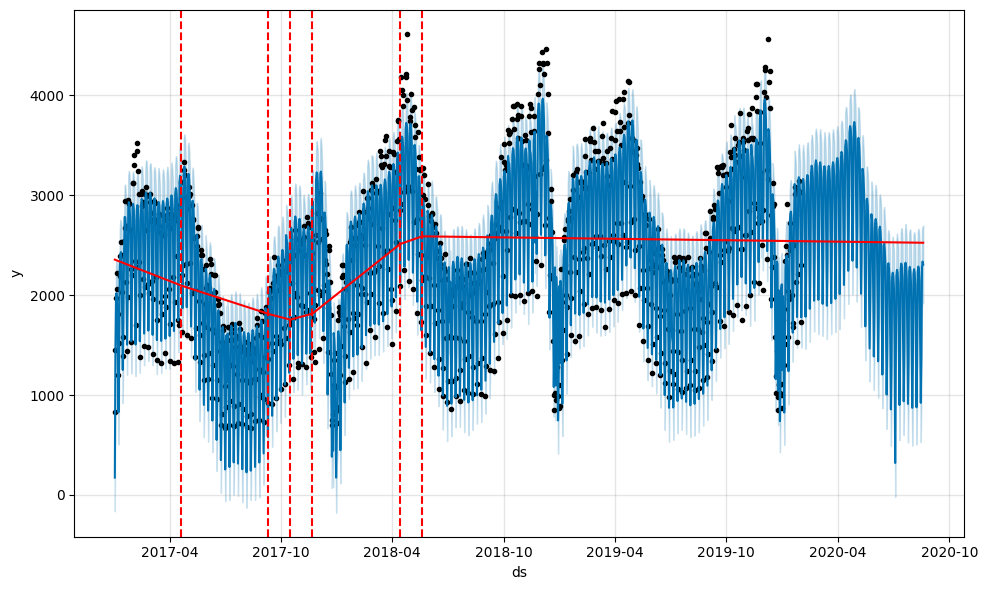

In [19]:
fig= m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Change Point Detection in Prophet

A change point in a time series refers to a point in time at which the statistical properties of the series, such as the mean, variance, or autocorrelation, change significantly. Change points can be caused by various factors, such as structural breaks, regime shifts, or external interventions. Change point detection (CPD) is important in time series analysis as it can help improve the accuracy of forecasts and provide insights into the underlying dynamics of the series.

Prophet is engineered to detect change points automatically. It conducts CPD by proposing a large number of potential locations where the rate of change can occur and then selecting the most relevant ones. By default, Prophet suggests 25 evenly spaced potential change points within the first 80% of the time series, then utilizes the minimum number necessary to accurately model the data.

Let’s see how to interpret a Prophet model.

## Model explainability

Model explainability refers to the ability to understand and interpret how a machine learning model makes predictions or decisions. It’s crucial because many modern machine learning models, such as deep neural networks, are often treated as “black boxes” due to their complex structures and the intricate relationships between input features and output predictions.

We want to understand how the trend and seasonality patterns are captured in the model and how the forecasts are generated. It can be done with one line of code:

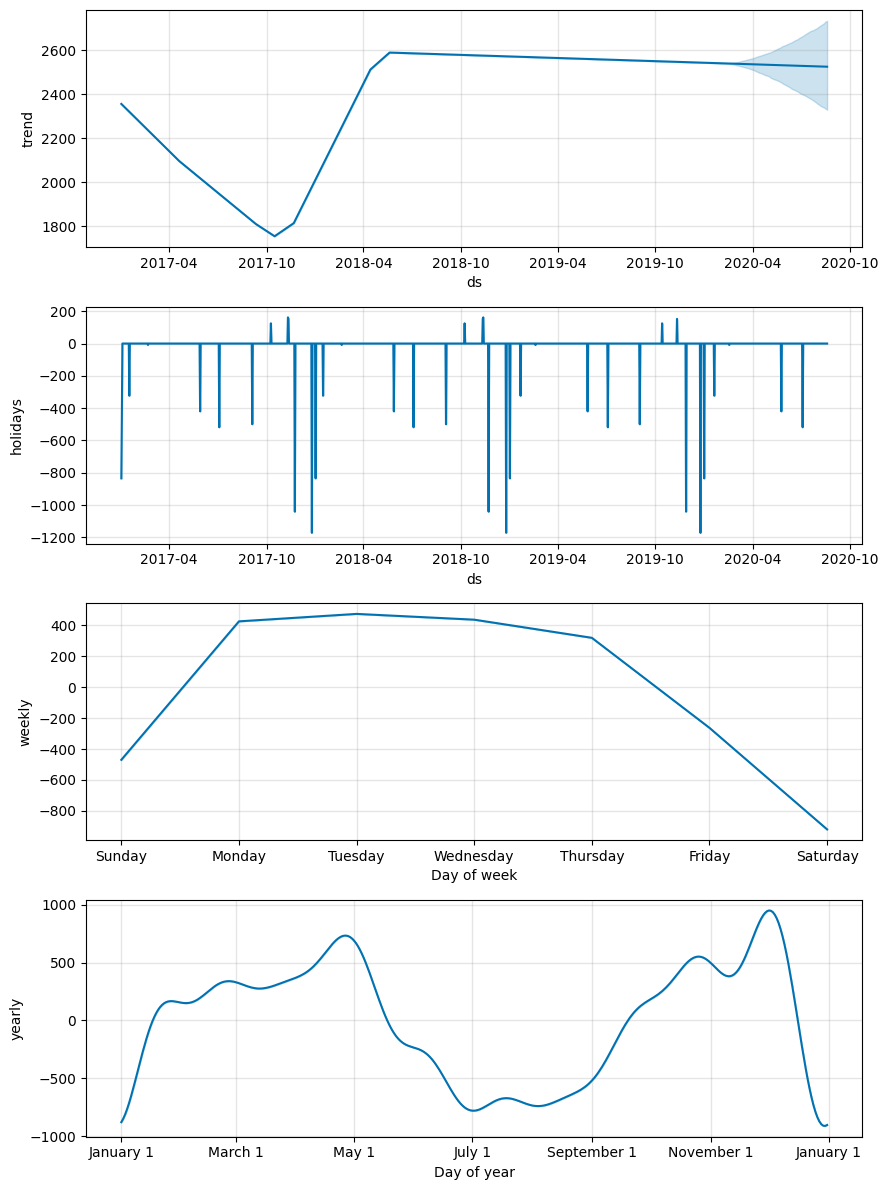

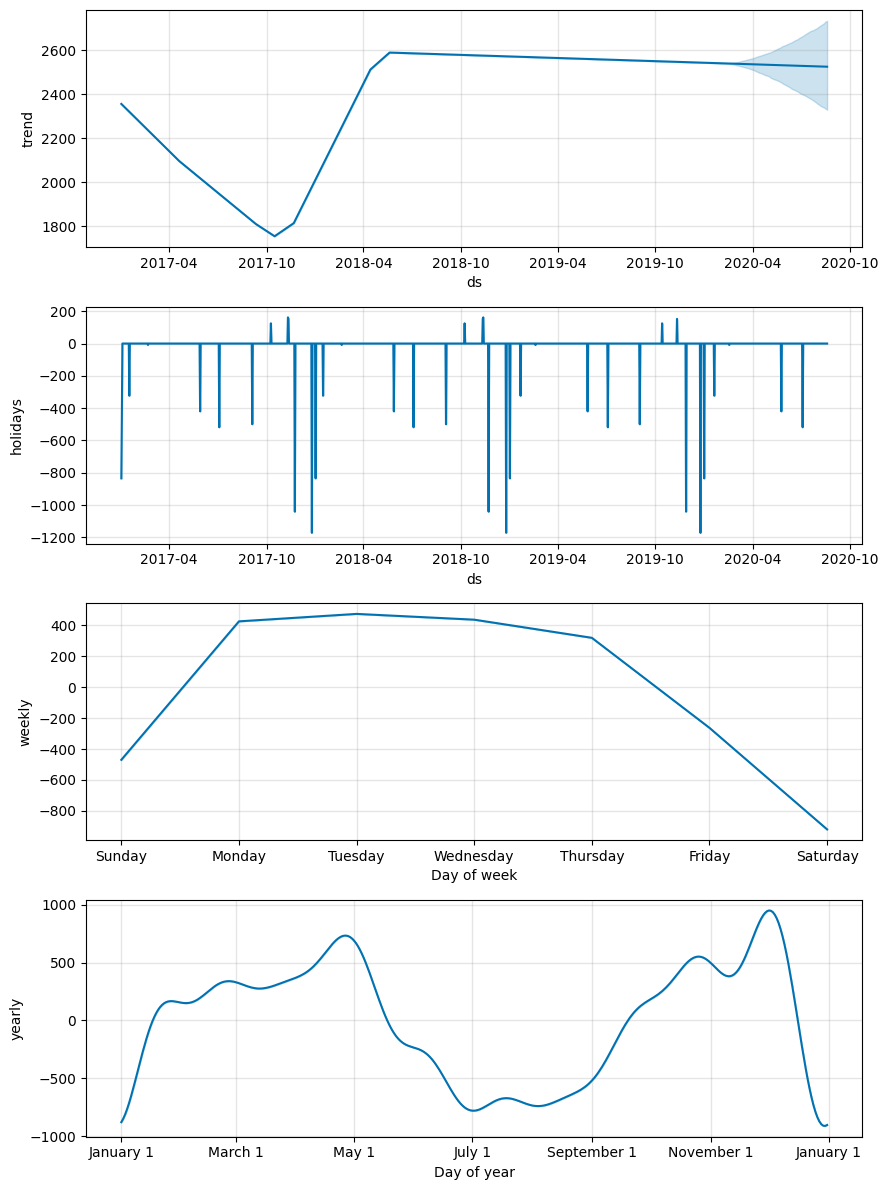

In [20]:
m.plot_components(forecast)

The trend pattern is shown in Figure (1). It indicates a downtrend in 2017, an uptrend in 2018, and a minor downtrend after 2018. Notice there is no uncertainty for the data in the training period up to 2020–02–01, and then the graph shows uncertainty for the days in the test period from 2020–02–02 to 2020–08–19.

The monthly pattern is one of the seasonal patterns as shown in Figure (4). This dataset is about the number of visitors to an academic website. It shows low traffic in July and August, likely due to summer vacations. It shows high traffic in May and December. The two months are around the due dates in the final weeks of the Spring and Fall semesters.


The weekday pattern is shown in Figure (3). The weekdays from Monday through Thursday have more visitors, and weekends have less traffic.

The holiday effects are shown in Figure (2). Holidays in Prophet are dummy variables, with 1.0 being yes and 0.0 being no. The value in the Y-axis is the impact on the target value, the traffic count. Most of the holidays have negative impacts on the traffic to the academic website, indicating less visits to the website.

Evaluating model performance is an important step. Let’s conduct it with the out-of-time test data.

## Out-of-time model performance

We will use the common metrics MAPE, MAE, and MSE for model performance introduced in Chapter 1: “Introduction”. Let’s just re-cap the three metrics.



*   Mean Absolute Percentage Error (MAPE): It measures the average absolute percentage difference between the predicted and actual values. It’s particularly useful when you want to understand the relative error compared to the actual values.
*   Mean Absolute Error (MAE): It measures the average absolute difference between the predicted and actual values. It gives equal weight to all errors without considering their direction (overestimation or underestimation).
*   Mean Squared Error (MSE): It measures the average squared difference between the predicted and actual values. Squaring the errors penalizes larger errors more heavily than smaller ones, making it sensitive to outliers.

They are available in the sklearn library.



In [23]:
mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))

print(f'mape: {mape}')
print(f'mae : {mae}')
print(f'mse : {mse}')

mape: 0.1567945479514208
mae : 395.1196126278681
mse : 236677.33445094927


The MAPE is 15.7%.

While this in-time and out-of-time approach is the general practice, in time series we seek model stability and performance for all periods. A model that performs very well in a specific period may not prevail in another period. What can we do? Prophet has a special diagnostic function to evaluate model performance through all periods.

## Model performance diagnostics through all periods

To ensure the model performance can stay stable through all periods, an intuitive way is to use the same setting to build multiple models for different periods, and “backtest” the models accordingly.
The diagnostic class of Prophet enables this procedure. It selects multiple cut points, fits the model with in-time data, and tests with the out-of-time data. This procedure is shown in Figure. The top graph is the case for “Cut date 1”. The data in the “Initial” period is used for model training, and the data in the “Horizon” period is used for model validation. The cut date then is moved to “Cute date 2” in the second graph train another model. The cross_validation function in the diagnostic class conducts the model iterations for multiple time windows.

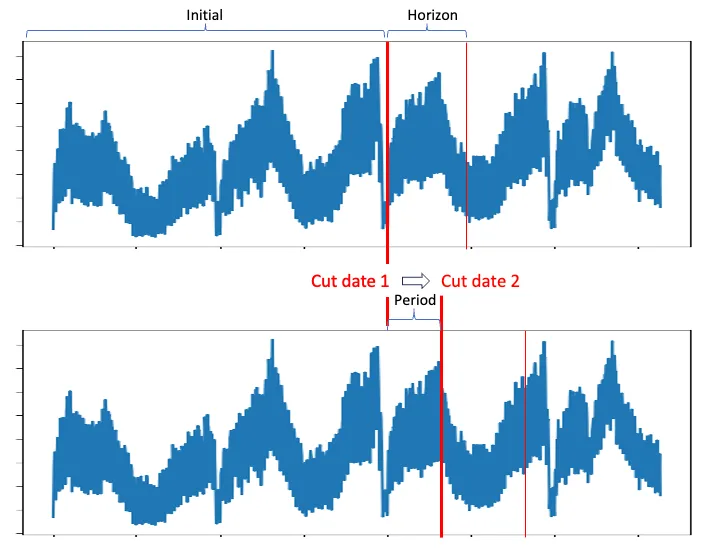

Prophet will select multiple cutoff points to build multiple models. The cross_validation function conducts the model iterations for multiple time windows.

In [26]:
# Diagnostics
m_cv = cross_validation(m,
                         initial='100 days',
                         period='180 days',
                         horizon = '365 days')
m_cv.head()

INFO:prophet:Making 4 forecasts with cutoffs between 2017-08-10 00:00:00 and 2019-02-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/nv4yvwwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/tcvtq9tt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44858', 'data', 'file=/tmp/tmplismcz65/nv4yvwwk.json', 'init=/tmp/tmplismcz65/tcvtq9tt.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelqdqku9f6/prophet_model-20240807181619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/1c0xlh_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/wo057y7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-11,917.134607,732.881315,1100.595193,1121,2017-08-10
1,2017-08-12,275.115625,103.535471,446.134880,669,2017-08-10
2,2017-08-13,650.771953,475.967767,831.628001,811,2017-08-10
3,2017-08-14,1476.426642,1308.461894,1649.573139,1346,2017-08-10
4,2017-08-15,1555.821534,1381.890370,1736.247696,1471,2017-08-10


Let’s review the above code:


*   initial: (optional). This is the size of the training data. It is 100 days in the example. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.
*   horizon: This is the forecasting horizon. The 365 days means we want to provide the forecasts for 365 days after the cutoff date.
*   period: This is the spacing between cut points. The parameter period specifies the period between models. It says the next cut point is 180 days after the previous cut point.

The m_cv data frame is a long outcome that contains the actual value y, the predicted mean yhat, the predicted lower bound yhat_lower and upper bound yhat_upper.

In [27]:
# Performance
from prophet.diagnostics import performance_metrics
m_perf = performance_metrics(m_cv)
m_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,124450.749961,352.775779,269.192201,0.147453,0.103660,0.176677,0.510274
1,38 days,129249.035888,359.512219,272.803273,0.146399,0.102130,0.175277,0.513699
2,39 days,131169.782863,362.173692,274.598371,0.145793,0.099615,0.174245,0.506849
3,40 days,137539.723056,370.863483,282.992235,0.148308,0.103660,0.177287,0.493151
4,41 days,144352.295527,379.937226,290.102369,0.150248,0.105260,0.179419,0.486301


The performance statistics by the performance_metrics include mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), symmetric MAPE, and coverage of the upper and lower bounds, as shown in table above. In time series, coverage of the upper bound and lower bound estimates refers to the proportion of actual values that fall within the predicted interval. Coverage is usually expressed as a percentage, and it’s a measure of how well the model’s uncertainty is calibrated. A coverage of 80% means that, on average, 80% of the time, the actual value falls within the predicted interval.

Hyperparameters are important in machine learning. Let’s understand what hyper-parameters are, and the hyperparameters in Prophet.

## Hyperpatameter tuning

In machine learning, a hyper-parameter is a parameter whose value is set before training a model, and it controls the model training process. Hyper-parameters are not learned from the data but rather are specified by the modeler or tuned using various methods. Hyper-parameters are important because they can significantly determine the predictability and training efficiency of a model. A good choice of hyperparameters can result in a model that generalizes well to new data, while a poor choice can lead to overfitting or underfitting.

We have learned Prophet can automatically determine a change point if it detects enough fluctuations. But how much fluctuation is large enough? There are two important hyperparameters that control the sensitivity of detecting the trend and seasonality patterns: change point_prior_scale for trend, and seasonality_prior_scale for seasonality. There is the hyperparameter seasonality_mode controlling for the model specifications whether the functional form whether it is additive or multiplicative.


*   changepoint_prior_scale is about the degree of flexibility to determine a change point in trend. A large value of change point_prior_scale will try to capture the fluctuation in time series with the trend term, resulting in more change points and capturing what could have been captured by yearly seasonality. A tuning range [0.001, 0.5] is recommended and the default is 0.05.
*   seasonality_prior_scale is about the degree of flexibility to determine seasonality. A large value will try to capture the fluctuation in the time series by the seasonality term. The default is 10. A turning rage [0.01, 10] is recommended and the default is 10.
*   seasonality_mode: Should the terms in GAM be additive or multiplicative? The two are ['additive', 'multiplicative'] and the default is 'additive'.

Prophet can automatically test other hyper-parameters, including n_changepoints, yearly_seasonality, weekly_seasonality, daily_seasonality, holidays, thus does not require rigorous tuning.

The preceding code demonstrates how to do grid searches for the three hyperparameters.

In [28]:
changepoint_prior_scale =  [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]
seasonality_prior_scale = [1, 5, 10, 15] # default 10
seasonality_model = ['additive', 'multiplicative']
results = []
iteration = 1
for sm in seasonality_model:
    for s in seasonality_prior_scale:
        for cp in changepoint_prior_scale:
            m = Prophet(
                seasonality_mode = sm,
                seasonality_prior_scale = s,
                changepoint_prior_scale = cp,
            )
            m.add_country_holidays(country_name='US')
            model = m.fit(train)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)

            mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
            mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
            mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))

            print(f'mape : {mape}')
            results.append([iteration, sm, s, cp,  mape, mae, mse])
            iteration += 1
results = pd.DataFrame(results, columns = ['iteration', 'seasonality_mode', 'seasonality_prior_scale', 'changepoint_prior_scale', 'mape', 'mae', 'mse'])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/3x7tm2rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/aok2vdxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90858', 'data', 'file=/tmp/tmplismcz65/3x7tm2rv.json', 'init=/tmp/tmplismcz65/aok2vdxv.json', 'output', 'file=/tmp/tmplismcz65/prophet_modely40jf71z/prophet_model-20240807182031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mape : 0.12534749374082282


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/lewc7_l9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/aqeyz9f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47664', 'data', 'file=/tmp/tmplismcz65/lewc7_l9.json', 'init=/tmp/tmplismcz65/aqeyz9f8.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelp6gloo67/prophet_model-20240807182033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/5kuhgkzn.json


mape : 0.1710217032467716


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/e8x7w40f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79591', 'data', 'file=/tmp/tmplismcz65/5kuhgkzn.json', 'init=/tmp/tmplismcz65/e8x7w40f.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelc3pxthk1/prophet_model-20240807182034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/r4qinpnk.json


mape : 0.2143768797020626


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/j3aduf6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75775', 'data', 'file=/tmp/tmplismcz65/r4qinpnk.json', 'init=/tmp/tmplismcz65/j3aduf6k.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelm1l_q2a0/prophet_model-20240807182036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/p35swpz6.json


mape : 0.208544652825


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/a90a2mbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19453', 'data', 'file=/tmp/tmplismcz65/p35swpz6.json', 'init=/tmp/tmplismcz65/a90a2mbg.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeln7wt2ujc/prophet_model-20240807182038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/nqhmql_6.json


mape : 0.16891804560791207


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/2tkde5qb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11130', 'data', 'file=/tmp/tmplismcz65/nqhmql_6.json', 'init=/tmp/tmplismcz65/2tkde5qb.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelxo339wzx/prophet_model-20240807182040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/04rjv5mn.json


mape : 0.10953856563876455


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/8kcf_tlg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51482', 'data', 'file=/tmp/tmplismcz65/04rjv5mn.json', 'init=/tmp/tmplismcz65/8kcf_tlg.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelj8jj4ix9/prophet_model-20240807182042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/nb6n5uux.json


mape : 0.12187194844313362


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/tm6qa0ec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10923', 'data', 'file=/tmp/tmplismcz65/nb6n5uux.json', 'init=/tmp/tmplismcz65/tm6qa0ec.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelt6vkui8i/prophet_model-20240807182043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/_p0f9ey9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/kprsiemk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

mape : 0.17610750484073073


18:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/0t7w82tw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/vov3rcj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86133', 'data', 'file=/tmp/tmplismcz65/0t7w82tw.json', 'init=/tmp/tmplismcz65/vov3rcj5.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelcsj2_gnw/prophet_model-20240807182045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.2107400027432578


18:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/__0cv47t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/g2d3qhuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48667', 'data', 'file=/tmp/tmplismcz65/__0cv47t.json', 'init=/tmp/tmplismcz65/g2d3qhuz.json', 'output', 'file=/tmp/tmplismcz65/prophet_model5484tw58/prophet_model-20240807182046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.19885975705055706


18:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/n0s3s3ir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/pvg558xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82306', 'data', 'file=/tmp/tmplismcz65/n0s3s3ir.json', 'init=/tmp/tmplismcz65/pvg558xq.json', 'output', 'file=/tmp/tmplismcz65/prophet_model2aa0iub_/prophet_model-20240807182047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.1526984861169494


18:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/l0q3gvm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/h7aflv80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33831', 'data', 'file=/tmp/tmplismcz65/l0q3gvm7.json', 'init=/tmp/tmplismcz65/h7aflv80.json', 'output', 'file=/tmp/tmplismcz65/prophet_modely0zh5hgz/prophet_model-20240807182048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.10542205454970999


18:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/xq74ujno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/p4uqpbpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23404', 'data', 'file=/tmp/tmplismcz65/xq74ujno.json', 'init=/tmp/tmplismcz65/p4uqpbpt.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelw15r7aet/prophet_model-20240807182049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.12299489039148562


18:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/kc1n0a_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/c_8lzdrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85766', 'data', 'file=/tmp/tmplismcz65/kc1n0a_q.json', 'init=/tmp/tmplismcz65/c_8lzdrx.json', 'output', 'file=/tmp/tmplismcz65/prophet_model6tkh3nxf/prophet_model-20240807182050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.17807793195374727


18:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/9e3k74yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4aqw0xcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90835', 'data', 'file=/tmp/tmplismcz65/9e3k74yp.json', 'init=/tmp/tmplismcz65/4aqw0xcf.json', 'output', 'file=/tmp/tmplismcz65/prophet_model3g95c58w/prophet_model-20240807182050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.21268184752991226


18:20:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/mbnxhjm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4z25acgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87301', 'data', 'file=/tmp/tmplismcz65/mbnxhjm3.json', 'init=/tmp/tmplismcz65/4z25acgk.json', 'output', 'file=/tmp/tmplismcz65/prophet_model686zbo53/prophet_model-20240807182051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.20813559189379055


18:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/5nxa3n76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/y61fsiqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71678', 'data', 'file=/tmp/tmplismcz65/5nxa3n76.json', 'init=/tmp/tmplismcz65/y61fsiqm.json', 'output', 'file=/tmp/tmplismcz65/prophet_model2dyisvr7/prophet_model-20240807182052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.16167454695165503


18:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/tfllu86e.json


mape : 0.11211711402727906


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/m6d8p5l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67884', 'data', 'file=/tmp/tmplismcz65/tfllu86e.json', 'init=/tmp/tmplismcz65/m6d8p5l6.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelc93espxt/prophet_model-20240807182054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/9lfxy883.json


mape : 0.1208545829777469


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/gbwx4h2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14633', 'data', 'file=/tmp/tmplismcz65/9lfxy883.json', 'init=/tmp/tmplismcz65/gbwx4h2v.json', 'output', 'file=/tmp/tmplismcz65/prophet_modellyw3_fvo/prophet_model-20240807182055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/5q_2qllk.json


mape : 0.1783395847265009


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/p65j8qrr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1614', 'data', 'file=/tmp/tmplismcz65/5q_2qllk.json', 'init=/tmp/tmplismcz65/p65j8qrr.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelp_rz05jg/prophet_model-20240807182056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4no35xtf.json


mape : 0.21213839210718366


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/pw20eh8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20185', 'data', 'file=/tmp/tmplismcz65/4no35xtf.json', 'init=/tmp/tmplismcz65/pw20eh8m.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelrvm49xlp/prophet_model-20240807182057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/ucgf7mc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4sp4zk44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

mape : 0.20755481291359767


18:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/2x5q9yz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/ub6_el2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15163', 'data', 'file=/tmp/tmplismcz65/2x5q9yz0.json', 'init=/tmp/tmplismcz65/ub6_el2u.json', 'output', 'file=/tmp/tmplismcz65/prophet_model3ipeevxz/prophet_model-20240807182100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.14856888176036587


18:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/hzk7lm40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/c0vmvlgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46705', 'data', 'file=/tmp/tmplismcz65/hzk7lm40.json', 'init=/tmp/tmplismcz65/c0vmvlgg.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelqe8_ncfl/prophet_model-20240807182101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.10820955746263305


18:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/au6j2fhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/_67n7yq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62992', 'data', 'file=/tmp/tmplismcz65/au6j2fhq.json', 'init=/tmp/tmplismcz65/_67n7yq4.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelcakxa0ue/prophet_model-20240807182102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.16156490134403748


18:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/mutfq6pb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/9861f8cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19436', 'data', 'file=/tmp/tmplismcz65/mutfq6pb.json', 'init=/tmp/tmplismcz65/9861f8cy.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeltdj5qeds/prophet_model-20240807182102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.18421121329699897


18:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/hbf5g6kz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/j_qc3j5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95636', 'data', 'file=/tmp/tmplismcz65/hbf5g6kz.json', 'init=/tmp/tmplismcz65/j_qc3j5n.json', 'output', 'file=/tmp/tmplismcz65/prophet_model5d47ne9d/prophet_model-20240807182103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.17892968992361769


18:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/r3qqchci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/b5uy0kiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73010', 'data', 'file=/tmp/tmplismcz65/r3qqchci.json', 'init=/tmp/tmplismcz65/b5uy0kiy.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelah0vda63/prophet_model-20240807182105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.14302227666218506


18:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/l973buo_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/fb0lgsp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23566', 'data', 'file=/tmp/tmplismcz65/l973buo_.json', 'init=/tmp/tmplismcz65/fb0lgsp4.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelipu3jaqo/prophet_model-20240807182106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.13878384681992562


18:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/sbvh97uc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/z1cptdg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53138', 'data', 'file=/tmp/tmplismcz65/sbvh97uc.json', 'init=/tmp/tmplismcz65/z1cptdg8.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelaq0_h1nu/prophet_model-20240807182107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.13956032419462802


18:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/b73ppys0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/i9rb10y5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59722', 'data', 'file=/tmp/tmplismcz65/b73ppys0.json', 'init=/tmp/tmplismcz65/i9rb10y5.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelllvjzu9_/prophet_model-20240807182108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.15959770300455403


18:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/w4ql45jb.json


mape : 0.18467018694197057


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/xa7eo6_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57332', 'data', 'file=/tmp/tmplismcz65/w4ql45jb.json', 'init=/tmp/tmplismcz65/xa7eo6_n.json', 'output', 'file=/tmp/tmplismcz65/prophet_model8pgjicxf/prophet_model-20240807182109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/da7etkbq.json


mape : 0.18316965701956703


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/sxkdlixf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38377', 'data', 'file=/tmp/tmplismcz65/da7etkbq.json', 'init=/tmp/tmplismcz65/sxkdlixf.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeljna6jjy6/prophet_model-20240807182110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/35_gs0zc.json


mape : 0.14346966774783299


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/3e7fhyx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84630', 'data', 'file=/tmp/tmplismcz65/35_gs0zc.json', 'init=/tmp/tmplismcz65/3e7fhyx_.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelwr6_ty0f/prophet_model-20240807182112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/vlesflja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/1av5n4vy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

mape : 0.13983086788969618


18:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/n9rwirix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4avzu93q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17934', 'data', 'file=/tmp/tmplismcz65/n9rwirix.json', 'init=/tmp/tmplismcz65/4avzu93q.json', 'output', 'file=/tmp/tmplismcz65/prophet_model518av802/prophet_model-20240807182115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.13804879808455414


18:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/3wgvdpkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/z02nzt3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61540', 'data', 'file=/tmp/tmplismcz65/3wgvdpkh.json', 'init=/tmp/tmplismcz65/z02nzt3u.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeljtrfg0zr/prophet_model-20240807182115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.16027737585468155


18:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/0c43dvjk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/sw15ha38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59386', 'data', 'file=/tmp/tmplismcz65/0c43dvjk.json', 'init=/tmp/tmplismcz65/sw15ha38.json', 'output', 'file=/tmp/tmplismcz65/prophet_modellawu73wg/prophet_model-20240807182116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.18438551989892063


18:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/wdno2hat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/y4rkf90x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77675', 'data', 'file=/tmp/tmplismcz65/wdno2hat.json', 'init=/tmp/tmplismcz65/y4rkf90x.json', 'output', 'file=/tmp/tmplismcz65/prophet_modely95aucnj/prophet_model-20240807182117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.17920494520168062


18:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/vix88gx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/2ugmdvtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34136', 'data', 'file=/tmp/tmplismcz65/vix88gx9.json', 'init=/tmp/tmplismcz65/2ugmdvtk.json', 'output', 'file=/tmp/tmplismcz65/prophet_model4rk_8czn/prophet_model-20240807182119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.14757986301136272


18:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/es1x4slv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/n70u1joi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89877', 'data', 'file=/tmp/tmplismcz65/es1x4slv.json', 'init=/tmp/tmplismcz65/n70u1joi.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelirmjve78/prophet_model-20240807182120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.13941447614788718


18:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/v7pw3f38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/dtvh29jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93450', 'data', 'file=/tmp/tmplismcz65/v7pw3f38.json', 'init=/tmp/tmplismcz65/dtvh29jg.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeln3gj5rjf/prophet_model-20240807182121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.14206697418797026


18:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/rmqcv_yf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/tffx514m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33552', 'data', 'file=/tmp/tmplismcz65/rmqcv_yf.json', 'init=/tmp/tmplismcz65/tffx514m.json', 'output', 'file=/tmp/tmplismcz65/prophet_model15wcautb/prophet_model-20240807182122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


mape : 0.17548184134568054


18:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/7yrpervs.json


mape : 0.1844151871836091


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/cmn9uqm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55730', 'data', 'file=/tmp/tmplismcz65/7yrpervs.json', 'init=/tmp/tmplismcz65/cmn9uqm0.json', 'output', 'file=/tmp/tmplismcz65/prophet_model89v7v6dh/prophet_model-20240807182123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/c67wzc0m.json


mape : 0.17985583985723771


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/y6l10_95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84273', 'data', 'file=/tmp/tmplismcz65/c67wzc0m.json', 'init=/tmp/tmplismcz65/y6l10_95.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeldoto9enp/prophet_model-20240807182124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/0du9o2uf.json


mape : 0.14202792811932827


DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/40xjbr7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33535', 'data', 'file=/tmp/tmplismcz65/0du9o2uf.json', 'init=/tmp/tmplismcz65/40xjbr7h.json', 'output', 'file=/tmp/tmplismcz65/prophet_model28spoc3a/prophet_model-20240807182126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/8wthxuse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/ai7bjd08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

mape : 0.1391307707814288


18:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


mape : 0.13888146566454265


Let’s sort the results by MAPE for the best model that delivers the smallest MAPE.

In [29]:
results.sort_values(by='mape').head()

,iteration,seasonality_mode,seasonality_prior_scale,changepoint_prior_scale,mape,mae,mse
11,12,additive,5,0.500,0.105422,267.311623,123097.341166
23,24,additive,15,0.500,0.108210,275.385473,128441.343234
5,6,additive,1,0.500,0.109539,279.008925,131226.733530
17,18,additive,10,0.500,0.112117,286.261999,136421.934761
18,19,additive,15,0.001,0.120855,298.438317,149767.694615


The first record is the best fine-tuned model. Let’s use it to perform model diagnostics through all periods.

In [30]:
sm = results.loc[0]['seasonality_mode']
sp = results.loc[0]['seasonality_prior_scale']
cp = results.loc[0]['changepoint_prior_scale']
m1 = Prophet(
        seasonality_mode = sm,
        seasonality_prior_scale = s,
        changepoint_range = cp,
    )
m1.add_country_holidays(country_name='US')
m1.fit(train)
future = m1.make_future_dataframe(periods=len(test), freq='D')
forecast = m1.predict(future)

# Diagnostics
from prophet.diagnostics import cross_validation
m1_cv = cross_validation(m1,
                         initial='100 days',
                         period='180 days',
                         horizon = '365 days')
# Performance 1
m1_perf = performance_metrics(m1_cv)
m1_perf.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/7097fpuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/50yi9dfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46233', 'data', 'file=/tmp/tmplismcz65/7097fpuw.json', 'init=/tmp/tmplismcz65/50yi9dfe.json', 'output', 'file=/tmp/tmplismcz65/prophet_modeljhwll30w/prophet_model-20240807182244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2017-08-10 00:0

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using -1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/krbq2mtk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/rgjvp8wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79374', 'data', 'file=/tmp/tmplismcz65/krbq2mtk.json', 'init=/tmp/tmplismcz65/rgjvp8wn.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelzbz2tadr/prophet_model-20240807182245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using -1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/4mz2bjlp.json
DEBUG:cmdstanpy:input tempfil

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,1.652467e+06,1285.483342,794.154387,0.536034,0.166321,0.528734,0.410959
1,38 days,1.655094e+06,1286.504621,794.536067,0.533277,0.166321,0.524026,0.410959
2,39 days,1.655041e+06,1286.484111,794.174821,0.529835,0.155521,0.517564,0.414384
3,40 days,1.659602e+06,1288.255502,798.404752,0.530039,0.170828,0.517354,0.410959
4,41 days,1.670248e+06,1292.380578,805.896696,0.531806,0.170828,0.518570,0.410959


The table shows the model performance diagnostics of this best model through all periods.

Shouldn’t the fine-tuned model outperform other models? This is a very interesting question. Remember the fine-tuned model is optimized to the specific training data. Although the tuning for theses hyperparameters help the model to perform well for the chosen training data, these fine-tuned hyperparameters may not perform as well in other training periods. It is reasonable to adopt the default settings of Prophet. If you do rigorous tuning to a particular training period, you are recommended to test the fine-tuned hyperparameters through all periods.

## Conclusions

We learned how Generalized Additive Models (GAMs) formulate business time series. We learned the Prophet module and how to interpret its outcomes. We learned the concept of model performance diagnostics through all periods, and experimented with the validity of hyperparameter tuning for a Prophet model.

Prophet is extended significantly to NeuralProphet which incorporates neural-network modules.

## Appendix: Prophet prediction intervals (Optional)

Prophet can provide uncertainty intervals through the use of Markov Chain Monte Carlo (MCMC) sampling techniques. This section just informs you about what it is designed to do.

Let’s explain how the Prophet designs uncertainty measures. It considers uncertainties that come from trend and seasonality. It uses MCMC to generate the uncertainties for trend and seasonality separately and then add them together. MCMC is a sampling technique that generates a sequence of samples from a distribution.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/li94ep6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplismcz65/5brjhm2a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77685', 'data', 'file=/tmp/tmplismcz65/li94ep6l.json', 'init=/tmp/tmplismcz65/5brjhm2a.json', 'output', 'file=/tmp/tmplismcz65/prophet_modelyhtsj3f4/prophet_model-20240807182547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


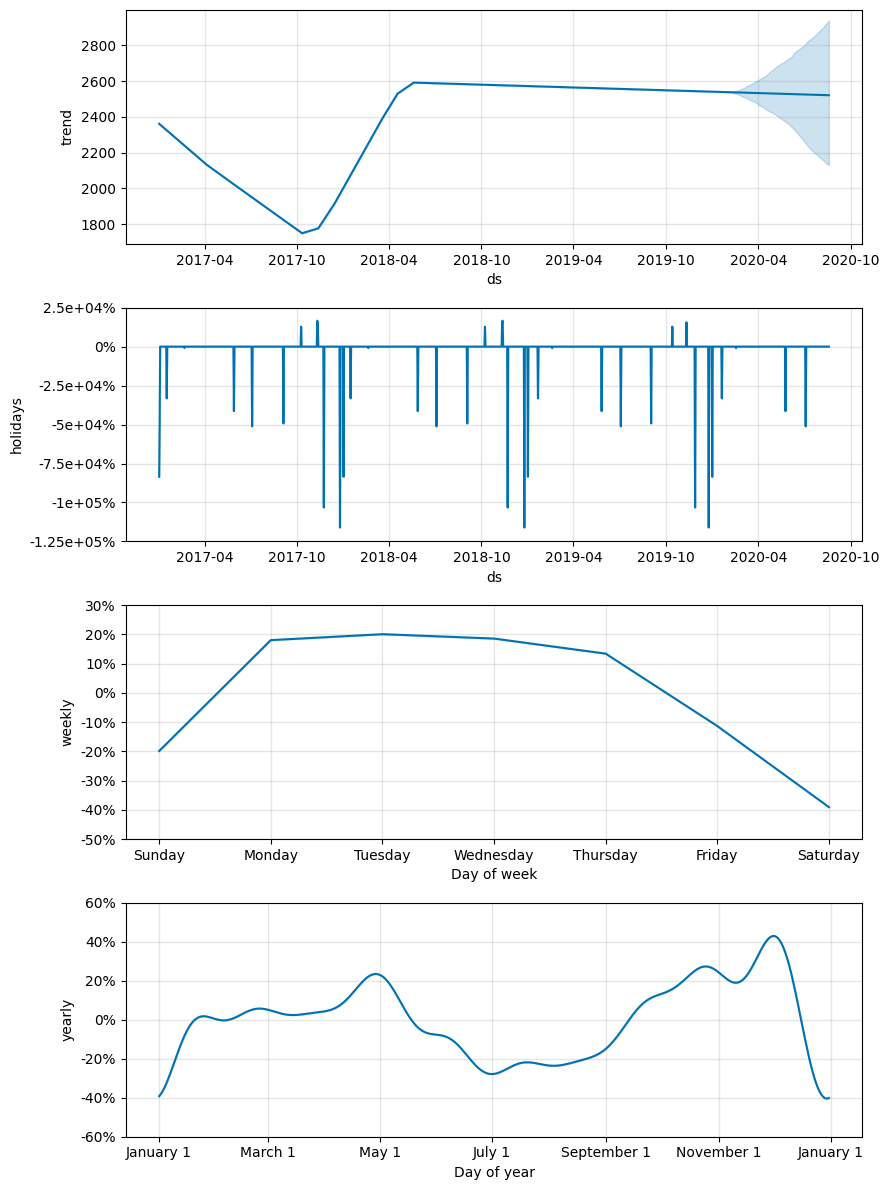

In [31]:
sm = 'additive'
sp = 15
cp = 0.7
m1 = Prophet(
        seasonality_mode = sm,
        seasonality_prior_scale = s,
        changepoint_range = cp,
        interval_width=0.95
    )
m1.add_country_holidays(country_name='US')
m1.fit(train)
future = m1.make_future_dataframe(periods=len(test), freq='D')
forecast = m1.predict(future)

# Python
fig = m.plot_components(forecast)